# Exploring the Lovecraft Corpus - Word Embeddings  
Ryan Folks  
DS5001  
vcz2aj@virginia.edu  

### Objective: The objective of this notebook is to apply word embeddings via the word2vec software to the lovecraft corpus.
---

In [4]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

In [18]:
OHCO = ['title','sent_num','token_num']\

w2v_params = dict(
    min_count = 10,
    workers = 4,
    # vector_size = 246,
    vector_size = 100,
    window = 2    
)

tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 40,
    n_components = 2,
    init = 'random',
    n_iter = 1000,
    random_state = 23    
)

In [8]:
TOKENS = pd.read_csv("data/output/lovecraft_CORPUS.csv").set_index(OHCO)
TOKENS = TOKENS.drop('para_num', axis=1)

In [9]:
TOKENS.head()

pos_tuple  pos token_str  \
title         sent_num token_num                                       
the alchemist 0        0              ('High', 'NNP')  NNP      High   
                       1                 ('up', 'RB')   RB        up   
                       2                   (',', ',')    ,         ,   
                       3          ('crowning', 'VBG')  VBG  crowning   
                       4                ('the', 'DT')   DT       the   

                                  term_str pos_group  
title         sent_num token_num                      
the alchemist 0        0              high        NN  
                       1                up        RB  
                       2                 ,         ,  
                       3          crowning        VB  
                       4               the        DT

In [10]:
VOCAB = TOKENS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['pos_max'] = TOKENS.value_counts(['term_str','pos']).unstack().idxmax(1)
VOCAB['pos_group'] = VOCAB.pos_max.str.slice(0,2)

Title significance

In [11]:
TITLES = TOKENS.groupby(OHCO[:2]+['term_str']).term_str.count()\
    .unstack(fill_value=0).astype('bool').astype('int')

In [12]:
TITLES

term_str                       !  #  $  &  '  ''  '10  '28  '45  '46  ...  \
title                sent_num                                         ...   
a garden             0         0  0  0  0  0   0    0    0    0    0  ...   
                     1         0  0  0  0  0   0    0    0    0    0  ...   
                     2         0  0  0  0  0   0    0    0    0    0  ...   
                     3         0  0  0  0  0   0    0    0    0    0  ...   
                     4         1  0  0  0  0   0    0    0    0    0  ...   
...                           .. .. .. .. ..  ..  ...  ...  ...  ...  ...   
what the moon brings 13        0  0  0  0  0   0    0    0    0    0  ...   
                     14        0  0  0  0  0   0    0    0    0    0  ...   
                     15        0  0  0  0  0   0    0    0    0    0  ...   
                     16        0  0  0  0  0   0    0    0    0    0  ...   
                     17        0  0  0  0  0   0    0    0    0    0  ...   

term_str                       κὀνις  μηδἐν  πἀντα  τὁ  —lucan  —maevius  \
title                sent_num                                              
a garden             0             0      0      0   0       0         0   
                     1             0      0      0   0       0         0   
                     2             0      0      0   0       0         0   
                     3             0      0      0   0       0         0   
                     4             0      0      0   0       0         0   
...                              ...    ...    ...  ..     ...       ...   
what the moon brings 13            0      0      0   0       0         0   
                     14            0      0      0   0       0         0   
                     15            0      0      0   0       0         0   
                     16            0      0      0   0       0         0   
                     17            0      0      0   0       0         0   

term_str                       —now  ’  “  ”  
title                sent_num                 
a garden             0            0  1  0  0  
                     1            0  1  0  0  
                     2            0  1  0  0  
                     3            0  0  0  0  
                     4            0  1  0  0  
...                             ... .. .. ..  
what the moon brings 13           0  0  0  0  
                     14           0  0  0  0  
                     15           0  0  0  0  
                     16           0  0  0  0  
                     17           0  0  0  0  

[19578 rows x 27570 columns]

In [13]:
VOCAB['df'] = TITLES.sum()
VOCAB['dfidf'] = VOCAB.df * np.log2(len(TITLES)/VOCAB.df)

In [14]:
VOCAB.sort_values('dfidf', ascending=False)

n pos_max pos_group    df         dfidf
term_str                                                  
in              9209      IN        IN  7275  10390.258597
a              10452      DT        DT  7457  10384.365755
to             11063      TO        TO  8142  10305.966647
was             7044     VBD        VB  6026  10243.963873
that            7096      IN        IN  5828  10188.280039
...              ...     ...       ...   ...           ...
narrator           1      NN        NN     1     14.256946
handily            1      RB        RB     1     14.256946
neutralisaton      1      NN        NN     1     14.256946
infest             1      VB        VB     1     14.256946
ante-mundane       1      JJ        JJ     1     14.256946

[27570 rows x 5 columns]

In [15]:
SENTS = TOKENS.groupby(OHCO[:-1]).term_str.apply(lambda  x:  x.tolist())

In [19]:
model = word2vec.Word2Vec(SENTS.values, **w2v_params)

In [20]:
W2V = pd.DataFrame(model.wv.get_normed_vectors(), index=model.wv.index_to_key)
W2V.index.name = 'term_str'
W2V = W2V.sort_index()

# tSNE visualizations

In [21]:
tsne_engine = TSNE(**tsne_params)
tsne_model = tsne_engine.fit_transform(W2V)

COORDS = pd.DataFrame(tsne_model, columns=['x','y'], index=W2V.index)\
    .join(VOCAB, how='left')[['x','y','n','dfidf','pos_group']]

COORDS

x          y     n        dfidf pos_group
term_str                                                   
!         -2.556331  46.546726   604  2966.442706         .
&         10.170317  11.912977    16   146.294272        CC
'         -3.114680  47.132626  1152  2933.767038        ''
''        -3.523960  46.038773   485  2368.763757        ''
'd       -26.401253  59.352631   157   917.237897        MD
...             ...        ...   ...          ...       ...
zenith     3.719013 -16.965096    12   128.063799        NN
zoogs     22.460257  21.059189    32   288.385233        NN
’        -47.470188  48.462212   950  2241.063634        NN
“        -16.705498  21.824694    17   146.294272        NN
”        -16.491644  21.951735    17   146.294272        NN

[5113 rows x 5 columns]

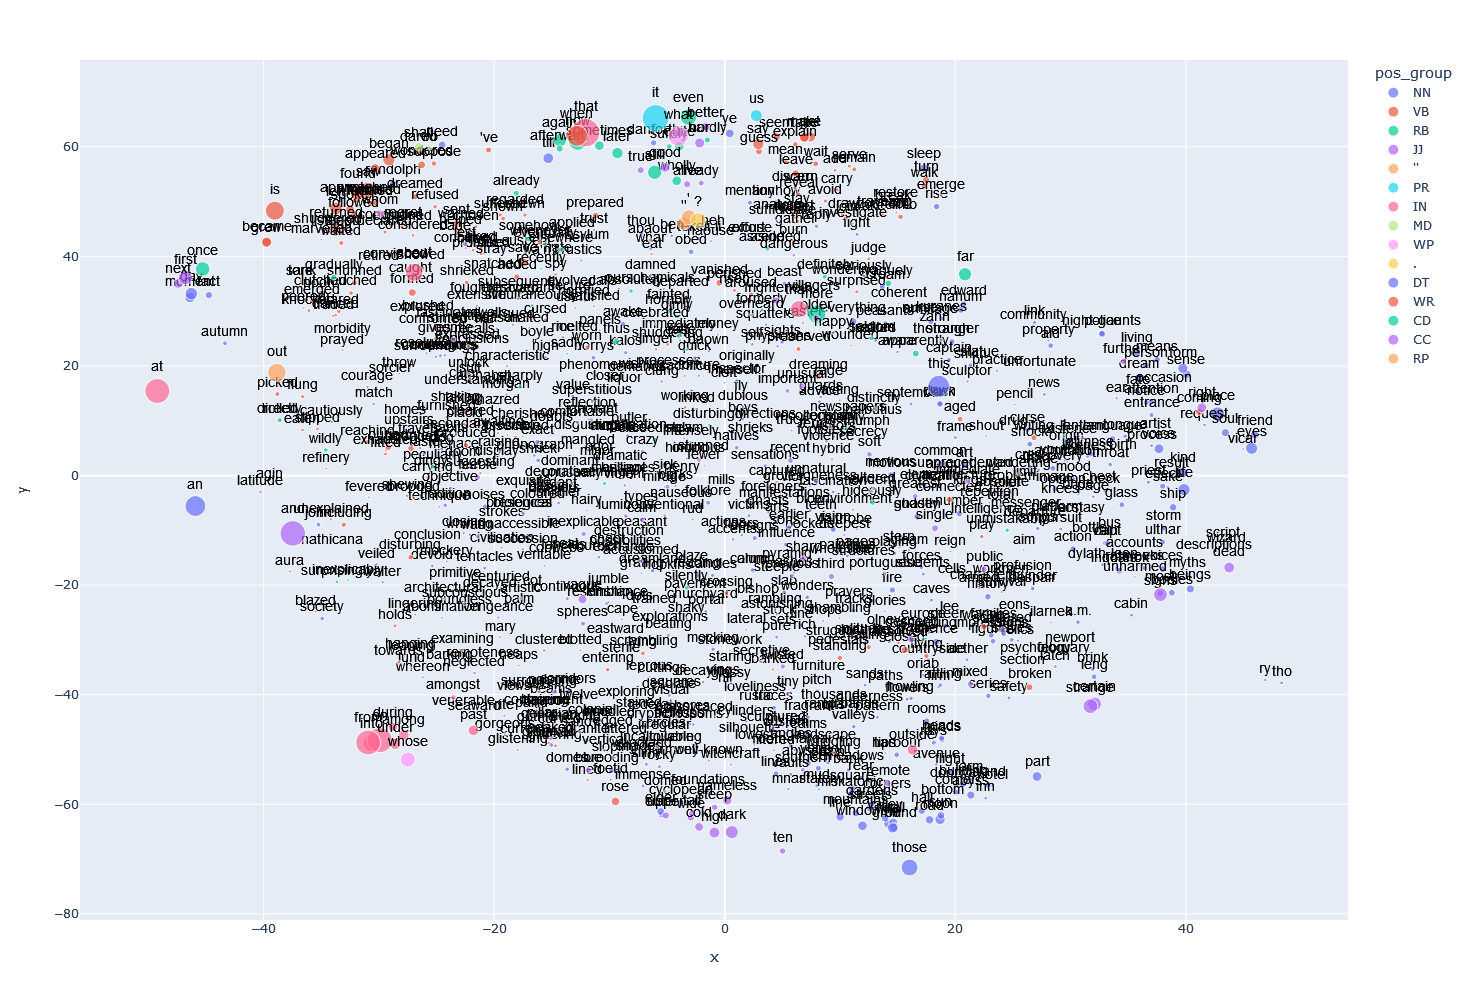

In [22]:
px.scatter(COORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

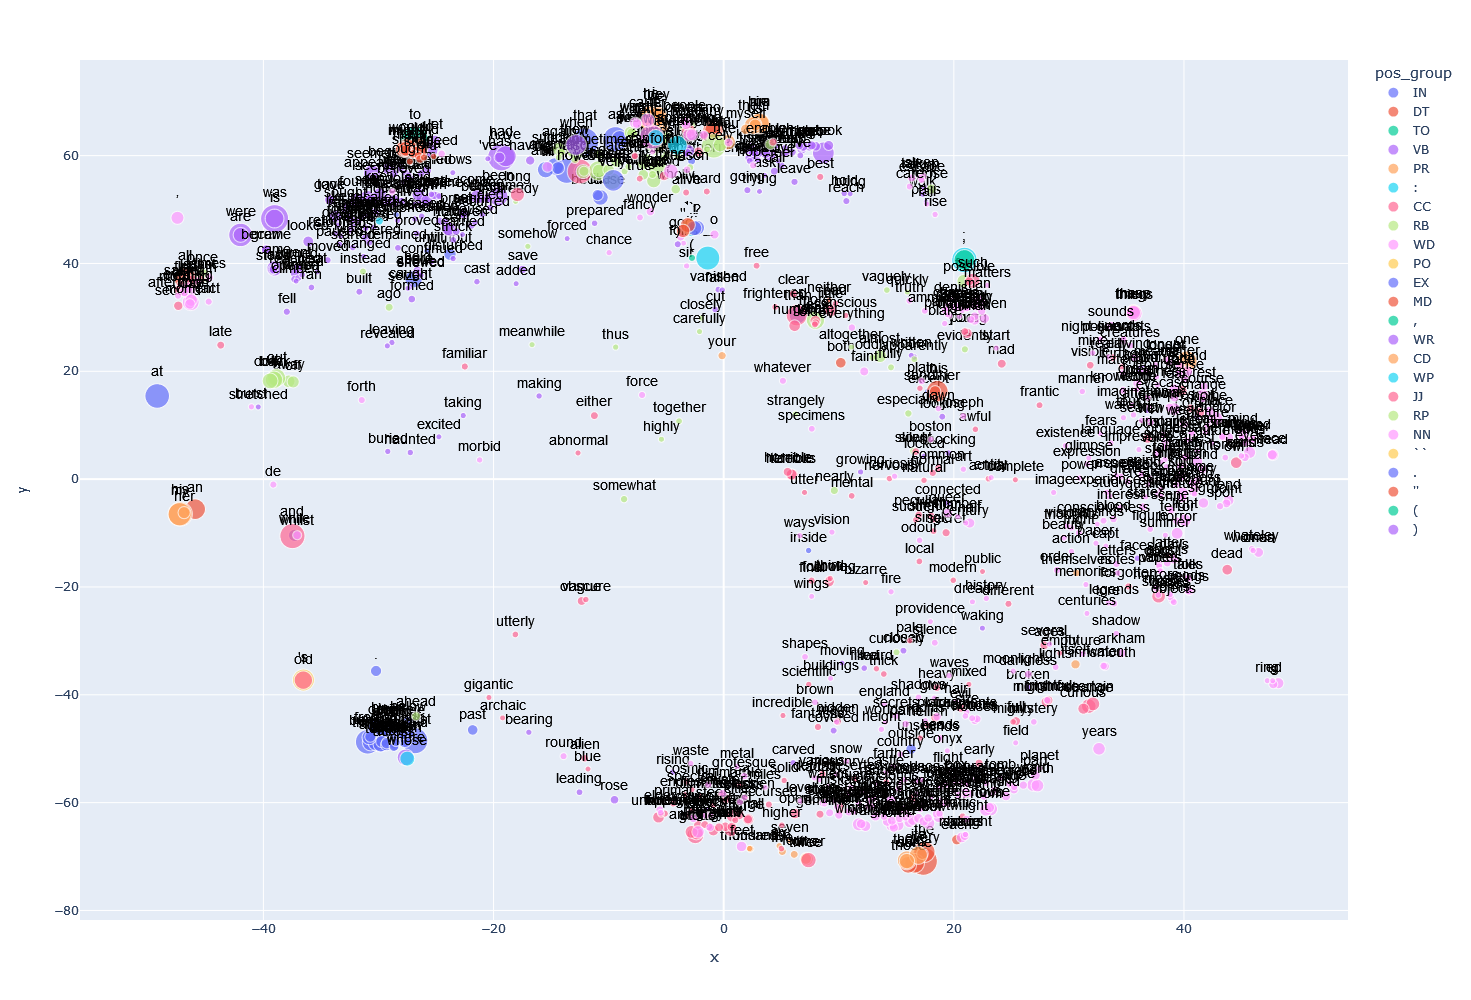

In [30]:
px.scatter(COORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

I have found the word race occurs here. Knowing Lovecraft, lets find out how its used.

In [28]:
[' '.join(j) for j in [i for i in SENTS if 'race' in i]]

['can revolution ’ s bitter precepts sway the soul that must the ties of race obey ?',
 "it must have formed the primary nucleus and center of some archaic and unbelievable chapter of earth 's history whose outward ramifications , recalled only dimly in the most obscure and distorted myths , had vanished utterly amidst the chaos of terrene convulsions long before any human race we know had shambled out of apedom .",
 'true , we had become visually familiar with the incredible secret concealed by the barrier peaks ; yet the prospect of actually entering primordial walls reared by conscious beings perhaps millions of years ago -- before any known race of men could have existed -- was none the less awesome and potentially terrible in its implications of cosmic abnormality .',
 'the technique , we soon saw , was mature , accomplished , and aesthetically evolved to the highest degree of civilized mastery , though utterly alien in every detail to any known art tradition of the human race .',

So he generally uses it as a word to mean "species" or "type", often to refer to aliens.